# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Traffic Sign Recognition Classifier

Deep learning example of classifying german traffic signs

---
## Step 0: Load Data

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
import csv
import os
import zipfile

from mpl_toolkits.axes_grid1 import ImageGrid
from collections import Counter
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from sklearn import preprocessing


train_zip = zipfile.ZipFile('data/train.p.zip', 'r')
valid_zip = zipfile.ZipFile('data/valid.p.zip', 'r')
test_zip = zipfile.ZipFile('data/test.p.zip', 'r')

train_zip.extractall('data/')
train_zip.close()

valid_zip.extractall('data/')
valid_zip.close()

test_zip.extractall('data/')
test_zip.close()

training_file = 'data/train.p'
validation_file = 'data/valid.p'
testing_file = 'data/test.p'
examples_file = 'data/examples.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(examples_file, mode='rb') as f:
    examples = pickle.load(f)
with open('data/signnames.csv', 'rt') as csvfile:
    class_labels = []
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        class_labels.append(row['SignName'])
        
os.remove('data/train.p')
os.remove('data/valid.p')
os.remove('data/test.p')
        
#Load and shuffle the training, validation, and test data
X_train, Y_train = train['features'], train['labels']
X_valid, Y_valid = valid['features'], valid['labels']
X_test, Y_test = test['features'], test['labels']

#Extract features and labels for 5 examples signs
X_examples, Y_examples = examples['features'], examples['labels']

assert(len(X_train) == len(Y_train))
assert(len(X_valid) == len(Y_valid))
assert(len(X_test) == len(Y_test))
assert(len(X_examples) == len(Y_examples))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_valid = len(X_valid)

# Number of testing examples
n_test = len(X_test)

# Shape of a traffic sign image
image_shape = X_train[0].shape

# Unique classes/labels in the dataset
n_classes = len(np.unique(np.concatenate((Y_train,Y_valid,Y_test))))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

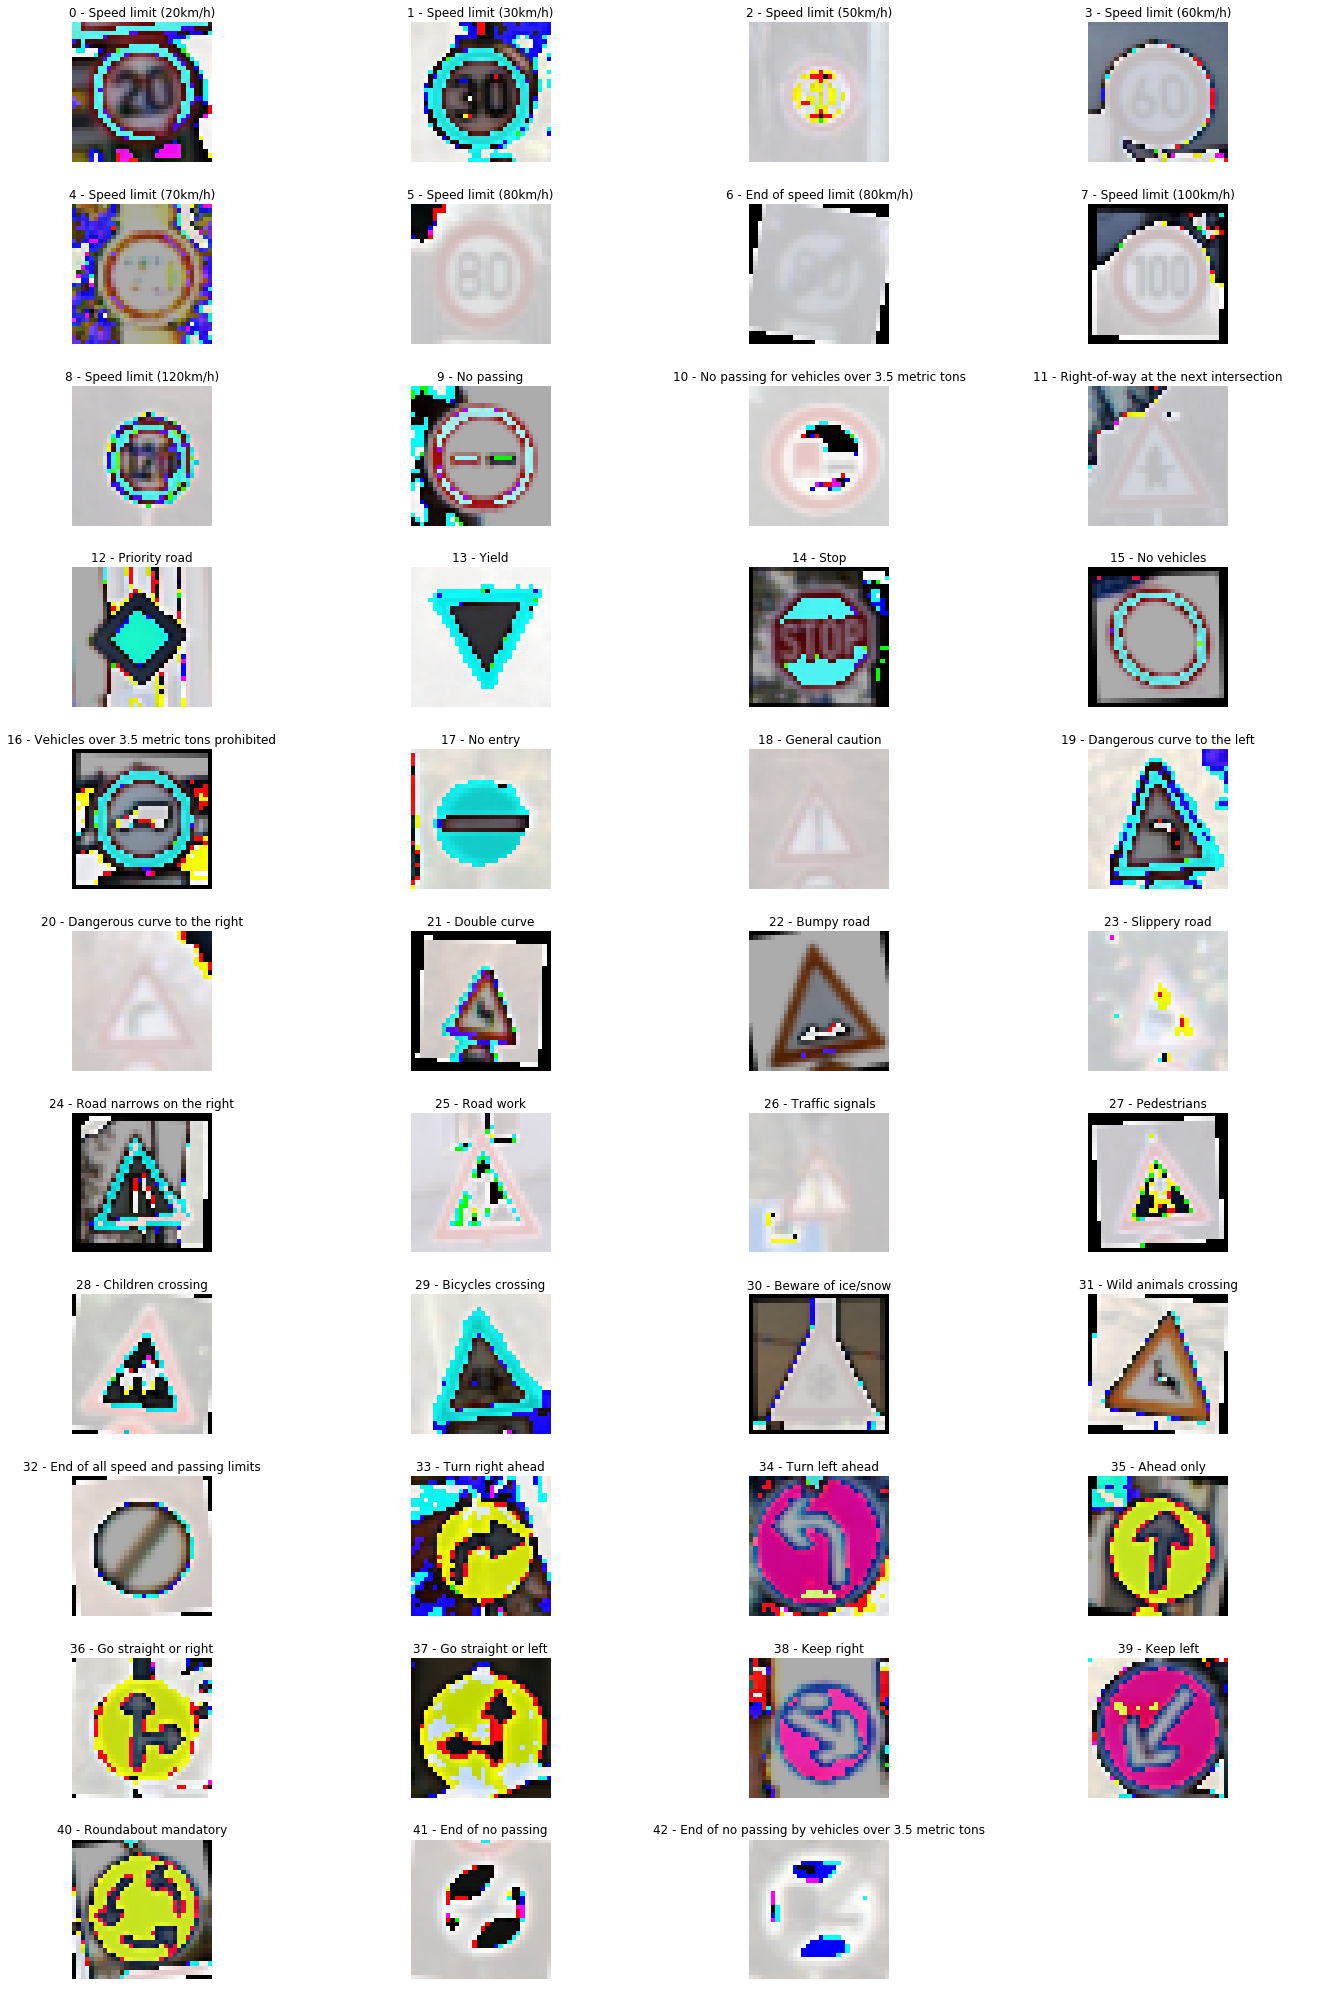

In [78]:
%matplotlib inline

#Instatiated a figure to display classification ids with their associated image
fig, axes = plt.subplots(11, 4, figsize=(24, 36), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)

#Turn off frame for each cell
np.vectorize(lambda axes:axes.axis('off'))(axes)

#Loop through all class labels and display the image classification
for x in range(0, n_classes):
    first_example_index = next(idx for idx, obj in enumerate(Y_train) if obj==x)
    axes.flat[x].imshow(X_train[first_example_index])
    axes.flat[x].set_title(str(x) + " - " + class_labels[x])

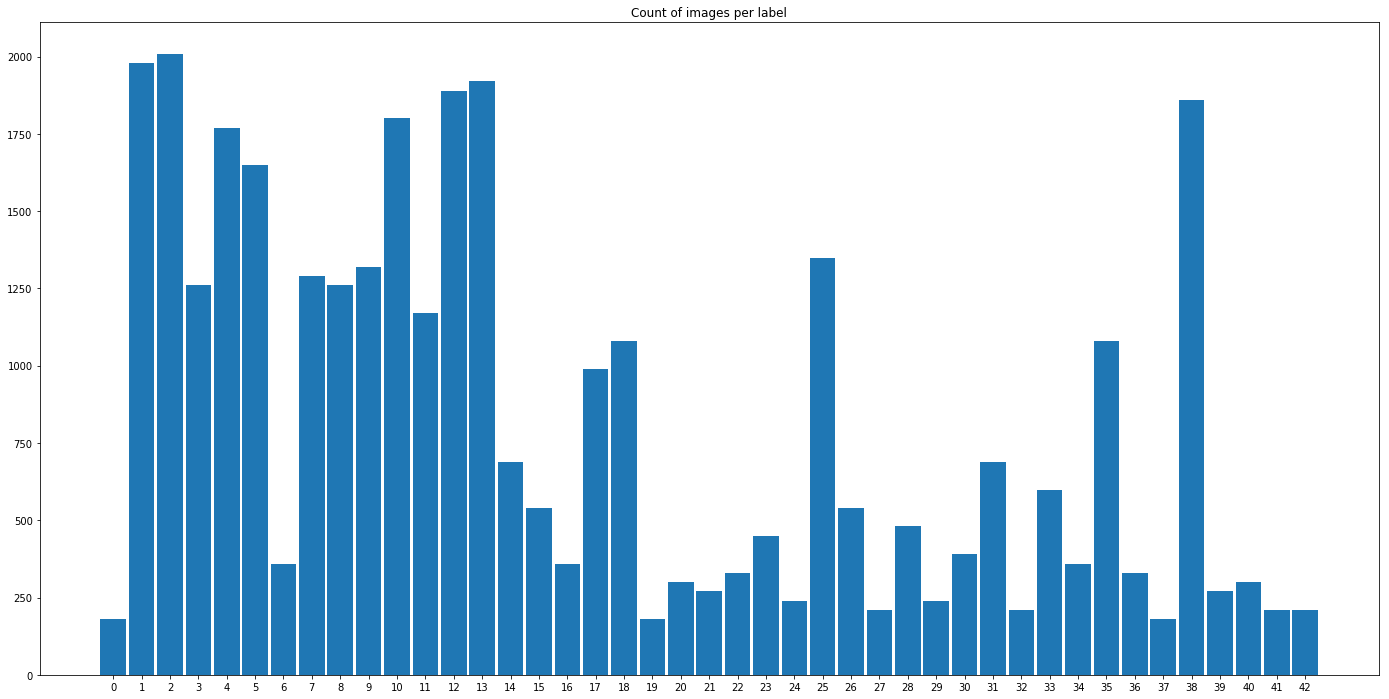

Max count of intial label training data =  2010
Label with max of intial label training data =  2
Mean of intial label training data =  809.279069767
Standard deviation of intial label training data =  619.420183705


In [4]:
Y_train_labels, Y_train_labels_values = zip(*Counter(Y_train).items())
maximum_labels_value = np.amax(Y_train_labels_values)
label_maximum_labels_value = np.argmax(Y_train_labels_values)
mean_count_of_labels = np.mean(Y_train_labels_values)
std = np.std(Y_train_labels_values)

plt.figure(figsize=(24, 12))
plt.bar(Y_train_labels, Y_train_labels_values, .9, align='center')
plt.xticks(Y_train_labels, Y_train_labels)
plt.title("Count of images per label")
plt.show(maximum_labels_value)

print("Max count of intial label training data = ", maximum_labels_value)
print("Label with max of intial label training data = ", label_maximum_labels_value)
print("Mean of intial label training data = ", mean_count_of_labels)
print("Standard deviation of intial label training data = ", std)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [5]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

In [74]:
### Useful functions for manipulating an image

def transformImageRandomly(image):
    rand_int = np.random.randint(0,1)
    if rand_int == 0:
        return rotateImageRandomly(image)
    if rand_int == 1:
        return resizeImage(image)

def resizeImage(image):
    rand_float = np.random.uniform(low=0.8, high=1.2, size=1)
    return cv2.resize(image, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)
    
def rotateImageRandomly(image):
    rand_float = np.random.uniform(low=0.8, high=1.2, size=1)
    rows,cols,color = image.shape
    center = (cols/2,rows/2)
    angle = np.random.randint(-10,10)
    scale = rand_float
    M = cv2.getRotationMatrix2D(center,angle,scale)
    transformed_image = cv2.warpAffine(image,M,(cols,rows))
    return transformed_image

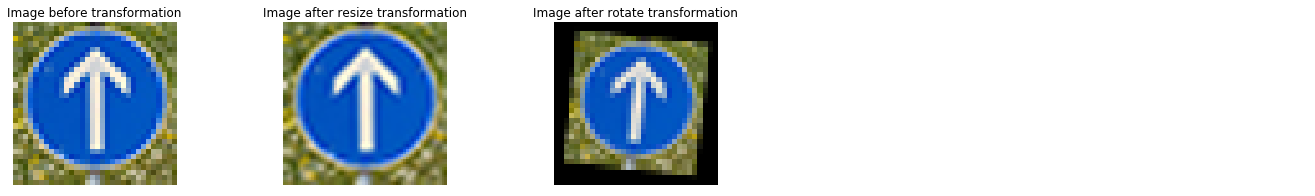

In [75]:
#Instatiated a figure to display classification ids with their associated image
fig, axes = plt.subplots(1, 5, figsize=(24, 3), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)

#Turn off frame for each cell
np.vectorize(lambda axes:axes.axis('off'))(axes)
    
axes.flat[0].imshow(X_examples[0])
axes.flat[0].set_title("Image before transformation")

axes.flat[1].imshow(resizeImage(X_examples[0]))
axes.flat[1].set_title("Image after resize transformation")

axes.flat[2].imshow(rotateImageRandomly(X_examples[0]))
axes.flat[2].set_title("Image after rotate transformation")

In [7]:
def normalizeImageArray(image_array):
    print("Mean before normalization =",np.mean(image_array))
    image_array = (image_array - image_array.mean())/(np.max(image_array) - np.min(image_array))
    print("Mean after normalization = ",np.mean(image_array))
    return image_array

X_train = normalizeImageArray(X_train)
X_valid = normalizeImageArray(X_valid)
X_examples = normalizeImageArray(X_examples)

Mean before normalization = 82.677589037
Mean after normalization =  -2.22061620326e-17
Mean before normalization = 83.5564273756
Mean after normalization =  8.97912801473e-19


In [8]:
from IPython.display import clear_output

for label, count in zip(Y_train_labels, Y_train_labels_values):
    for i in range(10):
        clear_output()
    print("Currently on label:",label)
    diff = maximum_labels_value - count
    if diff > 0:
        new_images = []
        new_image_labels = []
        for i in range(0, diff):
            if i < 2100:
                index = random.choice([idx for idx, obj in enumerate(Y_train) if obj == label])
                random_image = X_train[index]
                random_image = transformImageRandomly(random_image)
                random_image_label = Y_train[index]
                new_images.append(random_image)
                new_image_labels.append(random_image_label)
        X_train = np.concatenate((X_train,new_images),axis=0)
        Y_train = np.append(Y_train,new_image_labels)
    del new_images[:]
    del new_image_labels[:]

Currently on label: 42


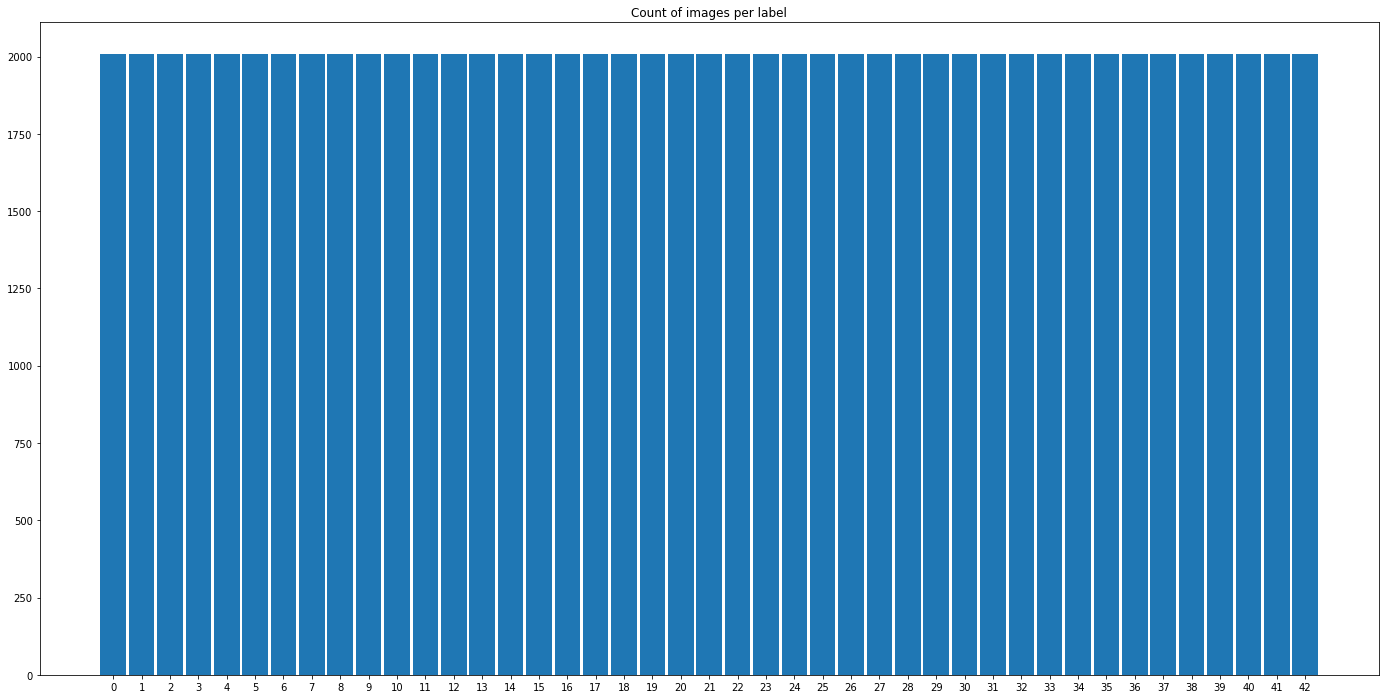

Max count of intial label training data =  2010
Label with max of intial label training data =  0
Mean of intial label training data =  2010.0
Standard deviation of intial label training data =  0.0


In [9]:
Y_train_labels, Y_train_labels_values = zip(*Counter(Y_train).items())
maximum_labels_value = np.amax(Y_train_labels_values)
label_maximum_labels_value = np.argmax(Y_train_labels_values)
mean_count_of_labels = np.mean(Y_train_labels_values)
std = np.std(Y_train_labels_values)

plt.figure(figsize=(24, 12))
plt.bar(Y_train_labels, Y_train_labels_values, .9, align='center')
plt.xticks(Y_train_labels, Y_train_labels)
plt.title("Count of images per label")
plt.show(maximum_labels_value)

print("Max count of intial label training data = ", maximum_labels_value)
print("Label with max of intial label training data = ", label_maximum_labels_value)
print("Mean of intial label training data = ", mean_count_of_labels)
print("Standard deviation of intial label training data = ", std)

In [10]:
EPOCHS = 5
BATCH_SIZE = 128


### Model Architecture

In [11]:

def TrafficSigns(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [22]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

rate = 0.001
logits = TrafficSigns(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [24]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, Y_train = shuffle(X_train, Y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, Y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './model/traffic_signs')
    print("Model saved")
    


Training...

EPOCH 1 ...
Validation Accuracy = 0.725

EPOCH 2 ...
Validation Accuracy = 0.839

EPOCH 3 ...
Validation Accuracy = 0.888

EPOCH 4 ...
Validation Accuracy = 0.897

EPOCH 5 ...
Validation Accuracy = 0.926

Model saved


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

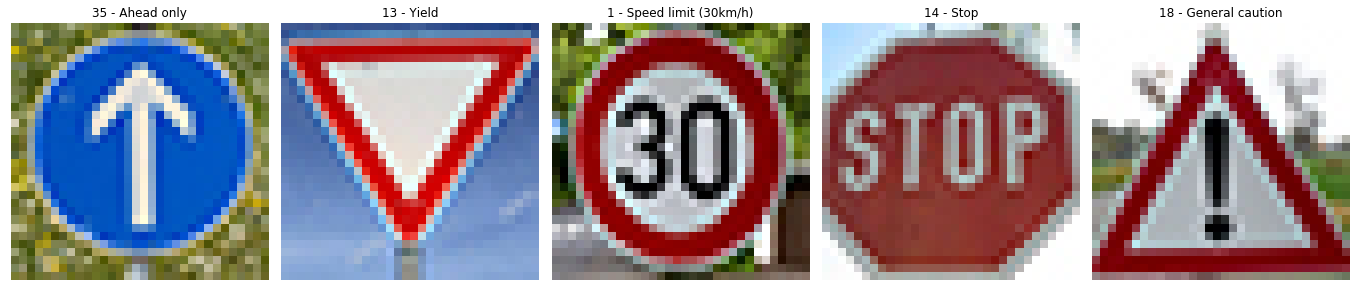

In [26]:
#Instatiated a figure to display classification ids with their associated image
fig, axes = plt.subplots(1, 5, figsize=(24, 24), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)

#Turn off frame for each cell
np.vectorize(lambda axes:axes.axis('off'))(axes)
    
#Loop through all class labels and display the image classification
for i in range(0, 5):
    axes.flat[i].imshow(X_examples[i])
    axes.flat[i].set_title(str(Y_examples[i]) + " - " + class_labels[Y_examples[i]])

### Predict the Sign Type for Each Image

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

from IPython.display import Image
a = cv2.cvtColor(cv2.imread("data/a.jpg"), cv2.COLOR_BGR2RGB)
b = cv2.cvtColor(cv2.imread("data/b.jpg"), cv2.COLOR_BGR2RGB)
c = cv2.cvtColor(cv2.imread("data/c.jpg"), cv2.COLOR_BGR2RGB)
d = cv2.cvtColor(cv2.imread("data/d.jpg"), cv2.COLOR_BGR2RGB)
e = cv2.cvtColor(cv2.imread("data/e.jpg"), cv2.COLOR_BGR2RGB)

print(a.shape)

test_pics = np.array([a,b,c,d,e])
test_labels = np.array([35,13,1,14,18])

d = {"features":test_pics,"labels":test_labels}

print(test_pics.shape)

with open('data/examples.p', 'wb') as f:
    pickle.dump(d, f)

with open('data/examples.p', mode='rb') as f:
    examples = pickle.load(f)

plt.imshow(test_pics[0])
plt.show()

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './model/traffic_signs')
    output = sess.run(tf.argmax(logits, 1), feed_dict={x: X_examples, keep_prob: 1.0})

for j in range(0,len(X_examples)):
    print("Predicted sign label:",output[j]," Actual label:", Y_examples[j])

### Analyze Performance

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './model/traffic_signs')
    output = evaluate(X_examples, Y_examples)
    print(output*100,"% Accurancy")

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, './model/traffic_signs')
    predicts = sess.run(tf.argmax(logits, 1), feed_dict={x: X_examples, keep_prob: 1.0})
print(predicts)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.